In [1]:
import os
import kagglehub

# Download the dataset using KaggleHub
dataset_name = "huizecai/mushroom"
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:", path)

100%|██████████| 470M/470M [00:07<00:00, 62.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huizecai/mushroom/versions/3


In [2]:
dataset_path = path + '/archive/data'
label_path = path + '/archive/label.txt'

# 获取所有子目录（即蘑菇类别）
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
categories = {}
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            category_name = parts[0]
            category_id = parts[1]
            categories[category_id] = category_name

# 统计每种类别的图像数量
category_counts = {}
for category_id in categories.keys():
    if category_id in dir_names:  # 确保目录存在
        category_dir = os.path.join(dataset_path, category_id)
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        category_counts[categories[category_id]] = num_images

print("Category counts:", category_counts)

Category counts: {'羊肚菌': 170, '牛肝菌': 157, '鸡油菌': 163, '鸡枞菌': 166, '青头菌': 193, '奶浆菌': 194, '干巴菌': 167, '虎掌菌': 187, '白葱牛肝菌': 190, '老人头菌': 176, '猪肚菌': 122, '谷熟菌': 171, '白参菌': 179, '黑木耳': 182, '银耳': 160, '金耳': 178, '猴头菇': 183, '香菇': 179, '平菇': 165, '金针菇': 140, '口蘑': 173, '鹿茸菇': 175, '榆黄蘑': 177, '榛蘑': 176, '草菇': 166, '鸡腿菇': 161, '茶树菇': 177, '蟹味菇': 146, '白玉菇': 158, '红菇': 184, '杏鲍菇': 162, '松茸': 191, '姬松茸': 185, '松露': 157, '竹荪': 184, '虫草花': 194}


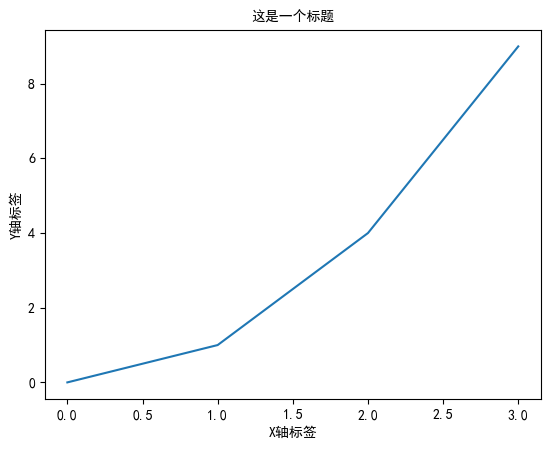

In [3]:
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, fontManager

# 下载并保存字体文件
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"
font_name = "SimHei.ttf"
if not os.path.exists(font_name):
    urllib.request.urlretrieve(font_url, font_name)

# 注册字体文件到matplotlib的字体管理器
fontManager.addfont(font_name)

# 设置字体属性
font_prop = FontProperties(fname=font_name)

# 确保matplotlib使用正确的字体族名称
plt.rcParams['font.family'] = 'SimHei'  # 这里应该是字体的family name，而不是文件名
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 示例绘图
plt.title('这是一个标题', fontproperties=font_prop)
plt.xlabel('X轴标签', fontproperties=font_prop)
plt.ylabel('Y轴标签', fontproperties=font_prop)
plt.plot([0, 1, 2, 3], [0, 1, 4, 9])
plt.show()

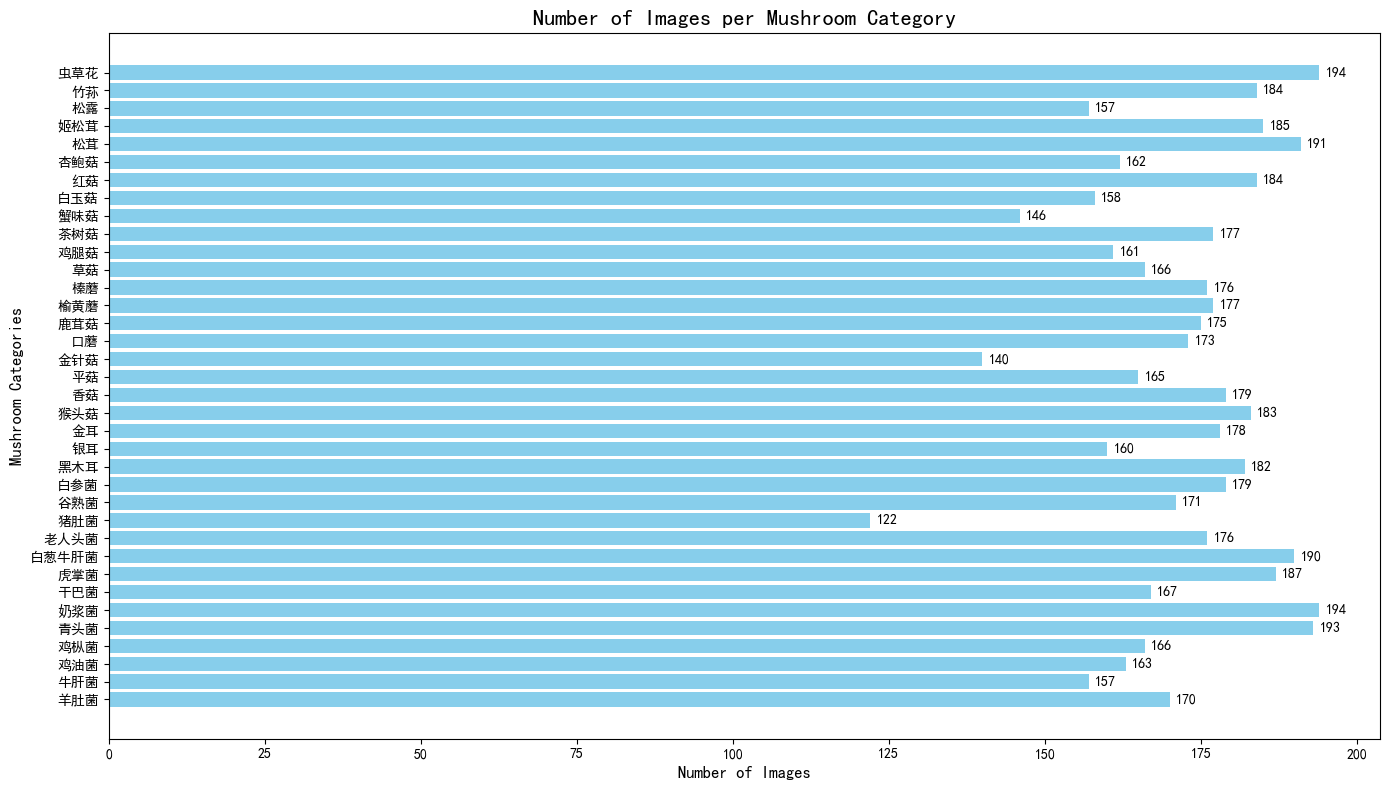

In [4]:
# 准备数据
categories_readable = list(category_counts.keys())
counts = list(category_counts.values())

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 绘制柱状图
bars = plt.barh(categories_readable, counts, color='skyblue')

# 添加数据标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, '%d' % int(width), va='center')

# 设置标题和标签
plt.title('Number of Images per Mushroom Category', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Mushroom Categories', fontsize=12)

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [5]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=21
)

Found 6188 files belonging to 36 classes.


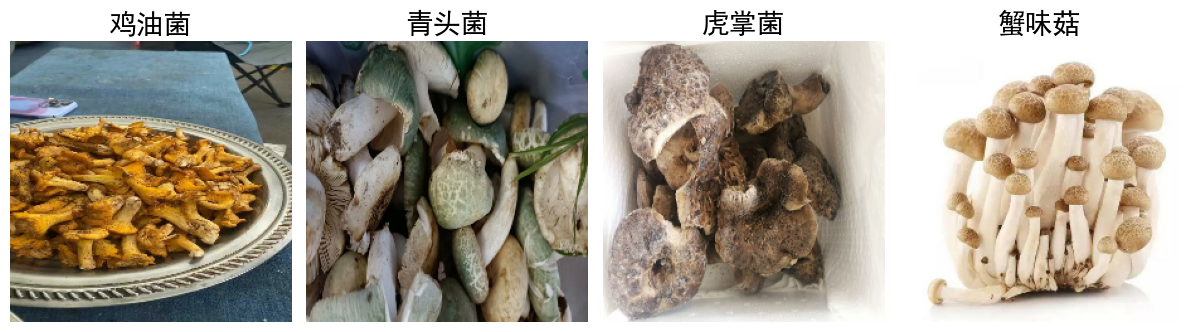

In [7]:
import numpy as np

class_names = dataset.class_names
num_images_to_show = 4
images_to_display = []
labels_to_display = []

for images, labels in dataset.take(1):
    indices = np.random.choice(range(images.shape[0]), num_images_to_show, replace=False)
    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(categories[class_names[np.argmax(label.numpy())]], fontsize=20)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [25]:
# 定义数据增强的预处理层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 水平翻转
    tf.keras.layers.RandomRotation(0.2),       # 随机旋转最多20%
    tf.keras.layers.RandomZoom(0.2, 0.2),      # 随机缩放
    tf.keras.layers.RandomContrast(0.2),       # 随机对比度调整
    tf.keras.layers.RandomBrightness(0.2)      # 随机亮度调整
])

In [26]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

In [29]:
# Get a batch of images
sample_batch = list(dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


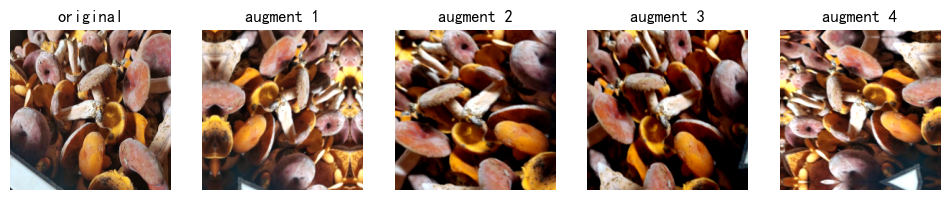

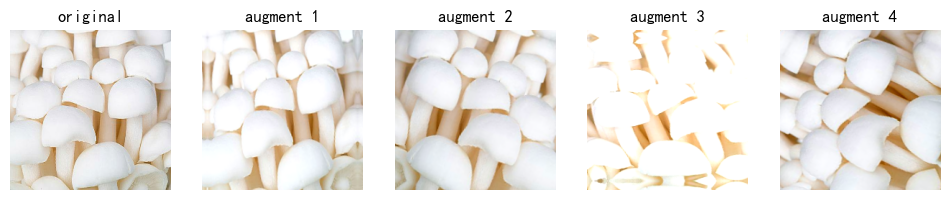

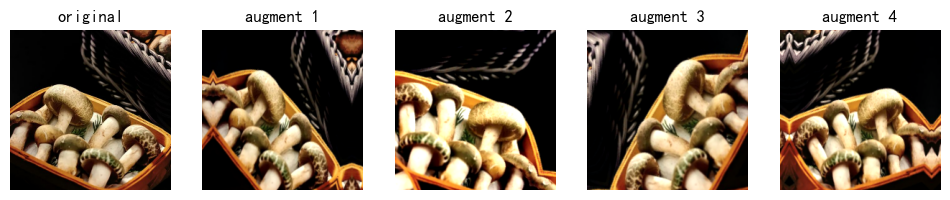

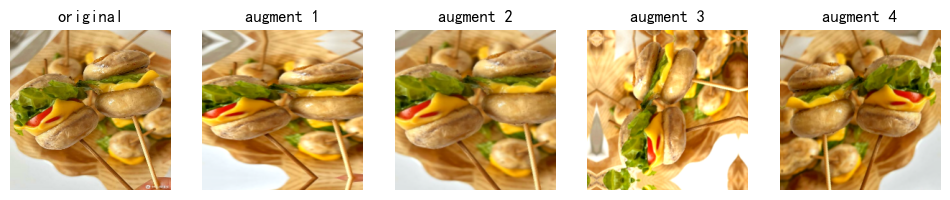

In [30]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Uncomment the line below to delete the variable to free up some memory
# del sample_batch